# Simple explainability of image-text similarity with CLIP

Using Gradient-activate Class Activation Maps for attention models as per [Chefer et al. 21'](https://arxiv.org/pdf/2103.15679).

This only uses the output of the last attention layer for now, could be extended to aggregate the outputs of all attention modules of the ViT part of the model.

Label: This is an image of species amabilis, in the genus Abies of family Pinaceae. It is part of the collection of institution A.


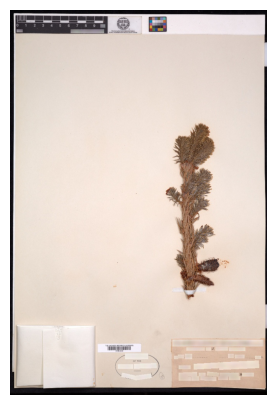

In [2]:
from PIL import Image
from matplotlib import pyplot as plt
from train_evaluation import ImageDatasetTrain, dataset, unique_captions, PRETRAINED_MODEL, MODEL_CPKT

train_dataset = ImageDatasetTrain(dataset['train']['image'][:50], dataset['train']['caption'][:50])
sample = train_dataset[0]

image, label, path = sample['pixel_values'], sample['label'], sample['path']

img = Image.open(path)
print(f"Label: {label}")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img)
ax.axis('off')
plt.show()

In [3]:
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained(MODEL_CPKT, cache_dir='.')
model = CLIPModel.from_pretrained(PRETRAINED_MODEL, cache_dir='.')

In [5]:
import torch

def interpret(img, prompt):
    inp = processor(
        text=[prompt],
        images=img,
        return_tensors="pt",
    )
    out = model(**inp, output_attentions=True)
    model.zero_grad()    
    logit = out.logits_per_image[0, 0]
    A = out.vision_model_output.attentions[-1]
    grad = torch.autograd.grad(logit, A)[0].detach()
    return (grad[0, :, 0, 1:] * A.detach()[0, :, 0, 1:]).clamp(min=0).mean(dim=0)

R = interpret(img, label)
R.size()

torch.Size([576])

This uses the attention weights and gradients of the last self-attention layer of CLIP's vision encoder, evaluating which areas are most relevant to the final similarity to the text prompt's embedding.

Finally, let's scale the relevancy map so it looks attractive, and visualize it:

(336, 336)
Label - 'This is an image of species amabilis, in the genus Abies of family Pinaceae. It is part of the collection of institution A.':


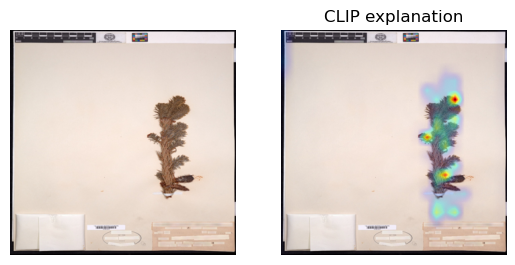

In [17]:
import cv2

#                                 this needs to adhere to the size of the relevancy matrix R
heatmap  = torch.nn.functional.interpolate(R.reshape(1, 1, 24, 24), size=336, mode='bilinear')[0, 0].numpy()
heatmap -= heatmap.min()
heatmap /= heatmap.max()
print(heatmap.shape)

fig, axs = plt.subplots(1, 2)

img_resized = img.resize((336, 336))
axs[0].imshow(img_resized)
axs[1].imshow(img_resized)

axs[1].imshow(heatmap, alpha=heatmap, cmap='jet')
axs[1].set_title('CLIP explanation')
for ax in axs:
    ax.axis('off')
print(f"Label - '{label}':")